### Detecting Credit Defaulting - Give me some Credit

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal is to build a model that borrowers can use to help make the best financial decisions.

### 1. Load the Dataset and prepare it for the algorithm
- Load the dataset, check the first five observations, check the column names, check the summary of the dataset (describe method) to see if there are any outliers or any missing values.

- If there are any outliers, cap the dataset with 0.95 quantile:
```
 x=data['columnname'].quantile(0.95)
 data['columnname']=np.where(data['columnname']>x,x,data['columnname'])
 ```
- If you see any need for scaling, scale the data column by dividing by maximum of that column

- Split data into atribute set and target

- split into test and train data sets



In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,StratifiedKFold
warnings.filterwarnings('ignore')
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Dropout, Activation
from keras.layers.normalization import BatchNormalization
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve,accuracy_score, classification_report


In [0]:
data = pd.read_csv('4-cs-training.csv')

In [0]:
data.describe()
#Data needs scaling for sure, min age is 0, imbalanced data, diff  between min and max a lot on some columns

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [0]:
#monthly income and number of dependents has null values
data.isnull().any()

Unnamed: 0                              False
SeriousDlqin2yrs                        False
RevolvingUtilizationOfUnsecuredLines    False
age                                     False
NumberOfTime30-59DaysPastDueNotWorse    False
DebtRatio                               False
MonthlyIncome                            True
NumberOfOpenCreditLinesAndLoans         False
NumberOfTimes90DaysLate                 False
NumberRealEstateLoansOrLines            False
NumberOfTime60-89DaysPastDueNotWorse    False
NumberOfDependents                       True
dtype: bool

In [0]:
#monthly income is null on a lot of rows
data['MonthlyIncome'].isnull().value_counts()

False    120269
True      29731
Name: MonthlyIncome, dtype: int64

In [0]:
# imputing missing values - with median
data = data.fillna(data.median())

In [0]:
#imbalanced data
data['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

In [0]:
#only one record where age = 0
(data['age']== 0).value_counts()

False    149999
True          1
Name: age, dtype: int64

In [0]:
data.loc[data["age"] == 0, "age"] = data.age.median()

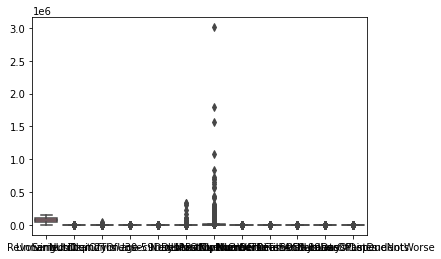

In [0]:
sns.boxplot(data=data)

In [0]:
# cols=data.columns
# fig=plt.figure(figsize=(20,50))
# for i in range(len(cols)):
#     if (i+1)!=len(cols):
#         plt.subplot(11,5,i+1)
#     plt.hist(data[cols[i]])
#     if i != 0:
#         plt.ylabel((data.columns[i-1])[0: 20], fontsize=20)
#     if (i+1)!=len(cols):
#         plt.xlabel((data.columns[i])[0: 20],fontsize=20)
# plt.tight_layout()
# plt.show()

In [0]:
X = data.drop("SeriousDlqin2yrs", axis=1) 
y = data["SeriousDlqin2yrs"]

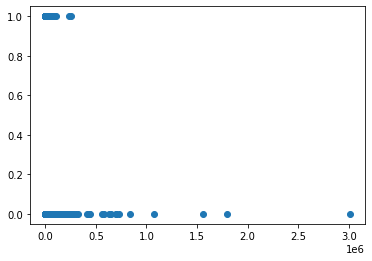

In [0]:
plt.scatter(X.MonthlyIncome,y)

In [0]:
#see outliers on RevolvingUtilizationOfUnsecuredLines, 'NumberOfTime30-59DaysPastDueNotWorse'
outliers = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 
            'DebtRatio','MonthlyIncome', 'NumberOfTimes90DaysLate' , 
            'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfDependents']

for columnname in outliers:
    x=X[columnname].quantile(0.95)
    X[columnname]=np.where(X[columnname]>x,x,X[columnname])

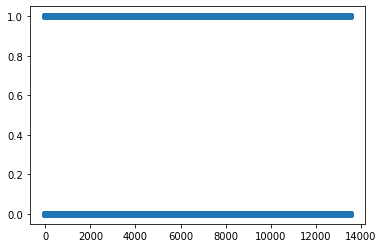

In [0]:
plt.scatter(X.MonthlyIncome,y)

In [0]:
X.describe()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.319196,52.295553,0.212873,254.635916,5924.638427,8.452760,0.055587,0.968253,0.050693,0.702453
std,43301.414527,0.349481,14.771249,0.523017,662.435683,3154.343174,5.145951,0.229123,0.921476,0.219371,1.001375
min,1.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.029867,41.000000,0.000000,0.175074,3903.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.154181,52.000000,0.000000,0.366508,5400.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.559046,63.000000,0.000000,0.868254,7400.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,109.000000,2.000000,2449.000000,13500.000000,58.000000,1.000000,3.000000,1.000000,3.000000


In [0]:
#scale the data column by dividing by maximum 
#of that column 
for i in X.columns.values:
    X[i] = X[i]/X[i].max()

In [0]:
X.describe()

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.500003,0.319196,0.479776,0.106437,0.103975,0.438862,0.145737,0.055587,0.322751,0.050693,0.234151
std,0.288676,0.349481,0.135516,0.261508,0.270492,0.233655,0.088723,0.229123,0.307159,0.219371,0.333792
min,0.000007,0.000000,0.192661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250005,0.029867,0.376147,0.000000,0.000071,0.289111,0.086207,0.000000,0.000000,0.000000,0.000000
50%,0.500003,0.154181,0.477064,0.000000,0.000150,0.400000,0.137931,0.000000,0.333333,0.000000,0.000000
75%,0.750002,0.559046,0.577982,0.000000,0.000355,0.548148,0.189655,0.000000,0.666667,0.000000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


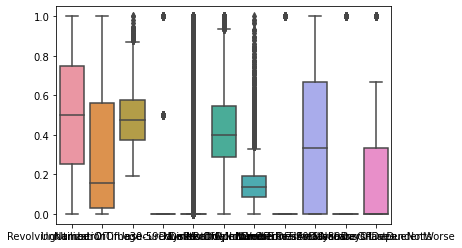

In [0]:
sns.boxplot(data=X)

In [0]:
X_train, X_test, y_train,y_test = train_test_split(X,y, random_state = 42)

### 2. Set up a baseline model 

- Use one hidden layer with activation 'relu'
- What activation should you use for output? Remember that this is a classification algorithm.
- Compile the model
- Fir the model, pick your epoch numbers and batch size. Use Test set as validation. 
- Visulaize train and test score as a function of epochs
- You can also use the `predict` method of your model and import `metrics` module from ScikitLearn to check accuracy metris in your test data set
- If you like you can use scikitlearn API for this section

In [0]:
def baseline_model():
    model = Sequential()
    model.add(Dense(200, input_dim=X_train.shape[1],activation = 'relu'))
    model.add(Dense(100,activation = 'relu'))
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
#try batch size 200 and epochs 150 and use colab
estimator=KerasClassifier(build_fn=baseline_model, batch_size=300, epochs=150,verbose=0)
kfold=StratifiedKFold(n_splits=5)
results=cross_val_score(estimator,X_train,y_train,cv=kfold)
print("mean score: ", results.mean())

mean score:  0.9287466645240784


In [0]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [0]:
#Model evaluation report
#confusion matrix
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))

#precision=TP/(TP+FP)
print("Precision score: " , precision_score(y_test, y_pred))

#recall=TP/(TP+FN)
print("Recall score: ", recall_score(y_test, y_pred))

#F1 score=TP/(TP+ (FP+FN/2)
print("F1 score: ", f1_score(y_test, y_pred))

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Confusion matrix: 
[[34383   642]
 [ 1981   494]]
Precision score:  0.43485915492957744
Recall score:  0.1995959595959596
F1 score:  0.273608418720576
Accuracy Score:  0.9300533333333333
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     35025
           1       0.43      0.20      0.27      2475

    accuracy                           0.93     37500
   macro avg       0.69      0.59      0.62     37500
weighted avg       0.91      0.93      0.92     37500



### 3. Controlling overfitting

- Import `l2` fom `keras` and introduce `kernel_regularization` to both layers of your model
- Run `0.75` dropout with `l2` regularization
- In addition to two steps above, now include `batch_normalization`
- At each step visualize how your model is responding

In [0]:
#baseline
model = Sequential()
model.add(Dense(1000,input_dim=X_train.shape[1],activation='relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1024, verbose=1)

Train on 112500 samples, validate on 37500 samples
Epoch 1/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2539 - accuracy: 0.9279 - val_loss: 0.1854 - val_accuracy: 0.9357
Epoch 2/100
112500/112500 [==============================] - 0s 3us/step - loss: 0.1843 - accuracy: 0.9354 - val_loss: 0.1805 - val_accuracy: 0.9362
Epoch 3/100
112500/112500 [==============================] - 0s 3us/step - loss: 0.1819 - accuracy: 0.9355 - val_loss: 0.1799 - val_accuracy: 0.9369
Epoch 4/100
112500/112500 [==============================] - 0s 3us/step - loss: 0.1814 - accuracy: 0.9356 - val_loss: 0.1795 - val_accuracy: 0.9367
Epoch 5/100
112500/112500 [==============================] - 0s 3us/step - loss: 0.1811 - accuracy: 0.9356 - val_loss: 0.1797 - val_accuracy: 0.9365
Epoch 6/100
112500/112500 [==============================] - 0s 3us/step - loss: 0.1809 - accuracy: 0.9357 - val_loss: 0.1796 - val_accuracy: 0.9362
Epoch 7/100
112500/112500 [============================

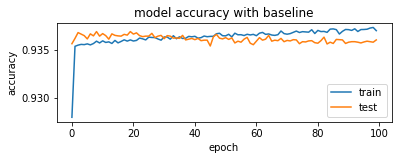

In [0]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with baseline')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [0]:
#kernel regularization
model = Sequential()
model.add(Dense(1000,input_dim=X_train.shape[1],activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(1,  activation='sigmoid',kernel_regularizer=l2(0.01)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1024, verbose=1)

Train on 112500 samples, validate on 37500 samples
Epoch 1/100
112500/112500 [==============================] - 1s 5us/step - loss: 0.3734 - accuracy: 0.9317 - val_loss: 0.2504 - val_accuracy: 0.9337
Epoch 2/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2404 - accuracy: 0.9329 - val_loss: 0.2314 - val_accuracy: 0.9340
Epoch 3/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2320 - accuracy: 0.9329 - val_loss: 0.2286 - val_accuracy: 0.9340
Epoch 4/100
112500/112500 [==============================] - 0s 3us/step - loss: 0.2304 - accuracy: 0.9329 - val_loss: 0.2277 - val_accuracy: 0.9340
Epoch 5/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2300 - accuracy: 0.9329 - val_loss: 0.2275 - val_accuracy: 0.9340
Epoch 6/100
112500/112500 [==============================] - 0s 3us/step - loss: 0.2298 - accuracy: 0.9329 - val_loss: 0.2275 - val_accuracy: 0.9340
Epoch 7/100
112500/112500 [============================

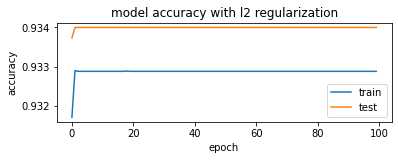

In [0]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with l2 regularization')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [0]:
#dropout
model = Sequential()
model.add(Dense(1000,input_dim=X_train.shape[1],activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.75))
model.add(Dense(1,  activation='sigmoid',kernel_regularizer=l2(0.01)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1024, verbose=1)

Train on 112500 samples, validate on 37500 samples
Epoch 1/100
112500/112500 [==============================] - 1s 5us/step - loss: 0.3756 - accuracy: 0.9273 - val_loss: 0.2514 - val_accuracy: 0.9339
Epoch 2/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2424 - accuracy: 0.9329 - val_loss: 0.2322 - val_accuracy: 0.9340
Epoch 3/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2340 - accuracy: 0.9329 - val_loss: 0.2296 - val_accuracy: 0.9340
Epoch 4/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2323 - accuracy: 0.9329 - val_loss: 0.2284 - val_accuracy: 0.9340
Epoch 5/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2321 - accuracy: 0.9329 - val_loss: 0.2279 - val_accuracy: 0.9340
Epoch 6/100
112500/112500 [==============================] - 0s 4us/step - loss: 0.2315 - accuracy: 0.9329 - val_loss: 0.2284 - val_accuracy: 0.9340
Epoch 7/100
112500/112500 [============================

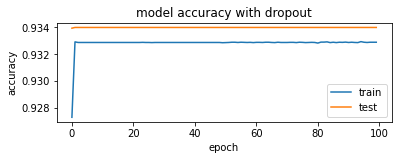

In [0]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with dropout')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [0]:
#batch normalization
model = Sequential()
model.add(Dense(1000,input_dim=X_train.shape[1],activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.75))
model.add(BatchNormalization())
model.add(Dense(1,  activation='sigmoid',kernel_regularizer=l2(0.01)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1024, verbose=1)

Train on 112500 samples, validate on 37500 samples
Epoch 1/100
112500/112500 [==============================] - 1s 7us/step - loss: 0.4473 - accuracy: 0.8805 - val_loss: 0.3019 - val_accuracy: 0.9340
Epoch 2/100
112500/112500 [==============================] - 1s 5us/step - loss: 0.2330 - accuracy: 0.9336 - val_loss: 0.2629 - val_accuracy: 0.9340
Epoch 3/100
112500/112500 [==============================] - 1s 5us/step - loss: 0.2095 - accuracy: 0.9342 - val_loss: 0.2483 - val_accuracy: 0.9340
Epoch 4/100
112500/112500 [==============================] - 1s 5us/step - loss: 0.2016 - accuracy: 0.9347 - val_loss: 0.2294 - val_accuracy: 0.9340
Epoch 5/100
112500/112500 [==============================] - 1s 5us/step - loss: 0.1979 - accuracy: 0.9340 - val_loss: 0.2087 - val_accuracy: 0.9340
Epoch 6/100
112500/112500 [==============================] - 1s 5us/step - loss: 0.1959 - accuracy: 0.9349 - val_loss: 0.1982 - val_accuracy: 0.9340
Epoch 7/100
112500/112500 [============================

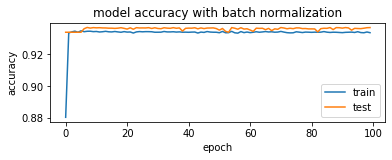

In [0]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with batch normalization')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### 4. Add more number of layers and repeat step 3.

In [0]:
model = Sequential()
model.add(Dense(1000,input_dim=X_train.shape[1],activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(500,activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(300,activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1,  activation='sigmoid',kernel_regularizer=l2(0.01)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1024, verbose=1)

Train on 112500 samples, validate on 37500 samples
Epoch 1/100
112500/112500 [==============================] - 1s 13us/step - loss: 3.4029 - accuracy: 0.8364 - val_loss: 0.6661 - val_accuracy: 0.9340
Epoch 2/100
112500/112500 [==============================] - 1s 8us/step - loss: 0.4815 - accuracy: 0.9290 - val_loss: 0.3849 - val_accuracy: 0.9340
Epoch 3/100
112500/112500 [==============================] - 1s 7us/step - loss: 0.3651 - accuracy: 0.9323 - val_loss: 0.3462 - val_accuracy: 0.9340
Epoch 4/100
112500/112500 [==============================] - 1s 8us/step - loss: 0.3173 - accuracy: 0.9329 - val_loss: 0.2950 - val_accuracy: 0.9340
Epoch 5/100
112500/112500 [==============================] - 1s 8us/step - loss: 0.2848 - accuracy: 0.9330 - val_loss: 0.2610 - val_accuracy: 0.9340
Epoch 6/100
112500/112500 [==============================] - 1s 8us/step - loss: 0.2668 - accuracy: 0.9331 - val_loss: 0.2530 - val_accuracy: 0.9361
Epoch 7/100
112500/112500 [===========================

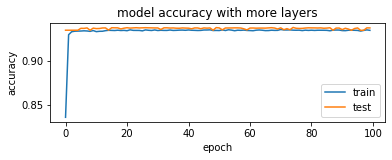

In [0]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with more layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [0]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

Error: 6.34%
